# Algoritmo de Metropolis
Arthur Souto Lima - 2018055113

## Imports e Funções Auxiliares

Imports de funções das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numba import jit

Importar funções auxiliares usadas em atividades anteriores para auxiliar nas computações.

In [3]:
from wang import (energy_ising, # calcula a energia da rede na configuração atual
                  neighbours,   # computa a matriz de vizinhança da rede
                  random_energy_state # cria uma configuração aleatória
                 )

## Implementação do Algoritmo de Metropolis

In [4]:
@jit(nopython=True) 
def expos(beta): 
    """
    Cria um vetor com o cálculo das exponenciais utilizadas.
    Isso economiza tempo nesse tipo de operação
    """
    ex = np.zeros(5,dtype=np.float32) 
    ex[0]=np.exp(8.0*beta) 
    ex[1]=np.exp(4.0*beta)
    ex[2]=0.0 
    ex[3]=np.exp(-4.0*beta) 
    ex[4]=np.exp(-8.0*beta) 
    return ex

In [5]:
@jit(nopython=True)
def mcstep(beta,s,viz,ener,mag):
    """
    Realiza um passo de Monte Carlo na rede s passada, à temperatura beta,
    com vizinhos viz
    """
    N = len(s) 
    ex = expos(beta) 
    for i in range(N): 
        # Soma dos vizinhos
        h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]]
        
        # Delta de energia se flipar esse sítio
        de = int(s[i]*h*0.5+2)
        
        if np.random.random() < ex[de]:
            # Aceita a nova configuração
            ener = ener+2*s[i]*h 
            mag  -= 2*s[i] 
            s[i] =- s[i]
    return ener,mag,s

In [6]:
@jit(nopython=True)
def metropolis(L, temp, s=None, steps=2000):
    """
    Simula uma rede NxN usando o algoritmo de Metropolis, à temperatura 'temp' (não é o beta)
    Pode receber o estado inicial 's'. Se não fornecido, é escolhido um estado aleatório inicial.
    Retorna dois arrays: energia e magnetização ao longo dos passos do algoritmo
    Por default, são 2000 passos, mas pode ser fornecido outro valor
    """
    # Criação da rede e seus parâmetros
    N = L**2
    beta = 1/temp
    if s is None: s = random_energy_state(N)
    viz = neighbours(N, L)
    ener = energy_ising(s, viz)
    mag = np.abs(np.sum(s))
    
    # Loop principal
    Es, mags = [], []
    Es.append(ener)
    mags.append(mag)
    for i in range(steps):
        ener, mag, s = mcstep(beta, s, viz, ener, mag)
        Es.append(ener)
        mags.append(np.abs(mag))
    return Es, mags

In [7]:
def metropolis_plt(ax, L, temp, qtd, steps=2000, legend=False, s=None, title=None):
    """
    Executa e plota resultados de simulações do algoritmo de Metropolis
    Pode-se definir quantas simulações são feitas com esses mesmos parâmetros
    Pode-se fornecer um estado inicial
    """
    for i in range(qtd):
        e, m = metropolis(L, temp, s=s, steps=steps)
        ax.plot(e,label=f"Energia {i+1}", alpha=0.7)
        ax.plot(m,label=f"Mag {i+1}", alpha=0.7)
    
    ax.set_title(f"Rede {L}x{L} - T={round(temp,1)}")
    
    if legend:
        # Ordena as legendas
        handles, labels = ax.get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.grid()

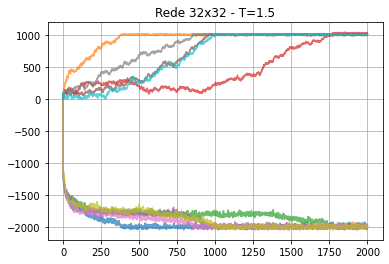

In [8]:
metropolis_plt(plt.gca(), 32, 1.5, 5)

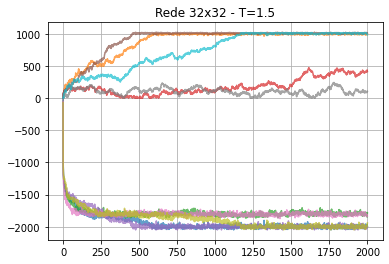

In [16]:
ax = plt.gca()
metropolis_plt(plt.gca(), 32, 1.5, 5)

## Simulações e Discussões

### Redes Genéricas

Inicialmente, vamos observar o comportamento de redes de tamanhos diferentes partindo de configurações aleatórias iniciais.

#### 32x32 genérica

Seguindo o exemplo do enunciado, vamos observar o comportamento de uma rede 32x32, entre 0.1 e 2.5 de temperatura, partindo sempre de uma configuração aleatória inicial.

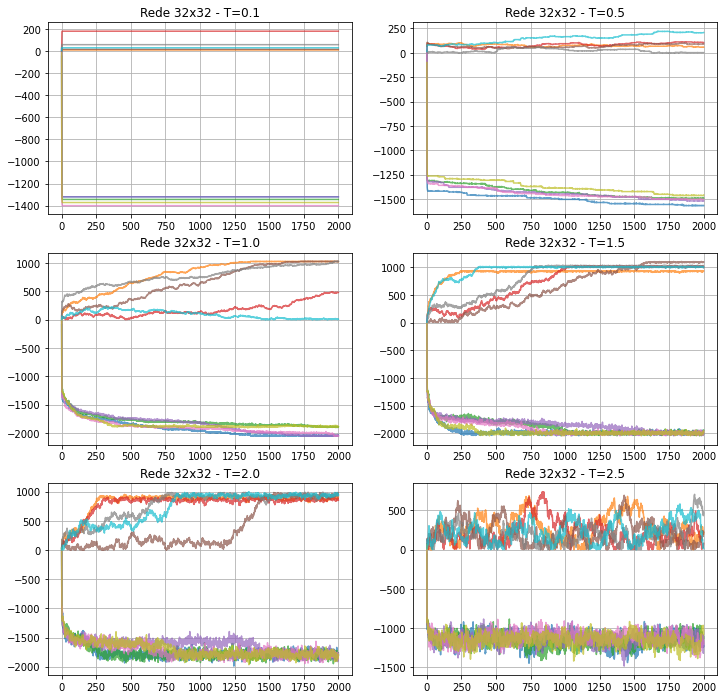

In [17]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    metropolis_plt(ax, L=32, temp=i, qtd=5, s=None, steps=2000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

Tal como alertado pelo enunciado, com temperaturas abaixo de 0.3, há um comportamento um pouco bizarro de forma que a energia e a magnetização ficam retas e constantes. No outro extremo, quando temos temperaturas maiores que 2.5, a magnetização não estabiliza mais e a energia fica oscilando em torno de um intervalo.

Em temperaturas intermediárias, no caso da rede 32x32 com configuração inicial aleatória, temos uma estabilização tanto da energia quanto da magnetização após cerca de 750 passos de Monte Carlo

#### 24x24 genérica

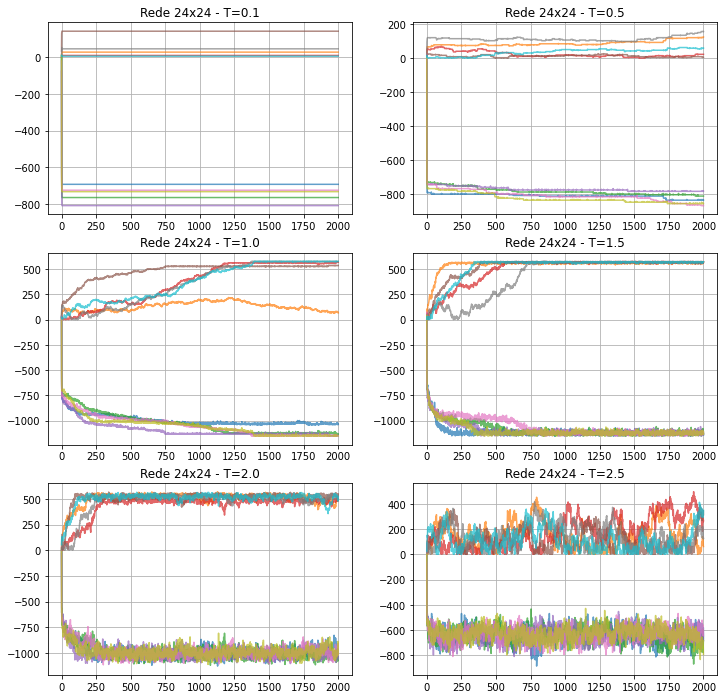

In [18]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
L = 24
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    metropolis_plt(ax, L=24, temp=i, qtd=5, s=None, steps=2000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

Aqui vemos que o comportamento caótico de altas temperaturas e retilíneo de baixas se mantêm. Nota-se, também, que com essa rede menor, estabiliza-se com apenas 250-300 passos, aproximadamente.

#### 64x64 genérica

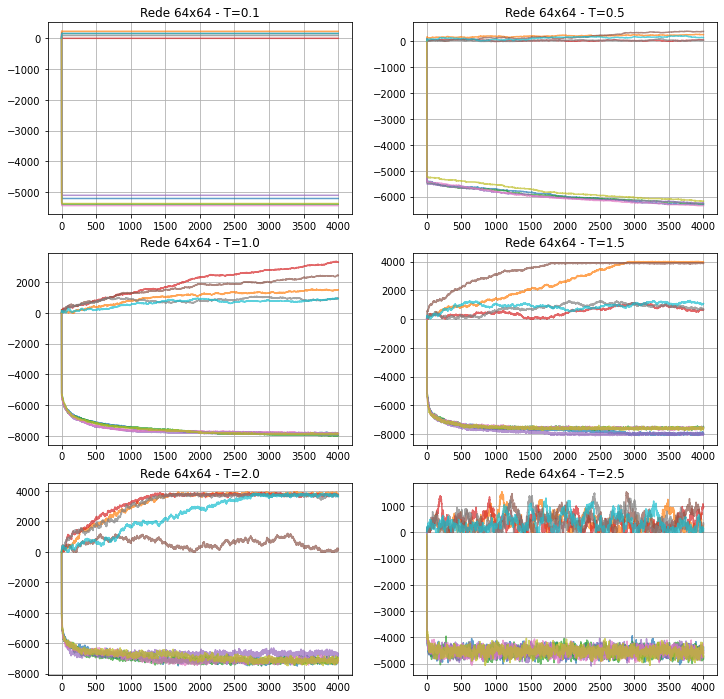

In [25]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
L = 24
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    metropolis_plt(ax, L=64, temp=i, qtd=5, s=None, steps=4000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

Mais uma vez, vê-se que o comportamento caótico de altas temperaturas e retilíneo de baixas se mantêm. Corroborando nossa análise, uma rede maior levou mais tempo para se estabilizar, no caso, em torno de 1500 passos aqui.

#### 100x100 genérica

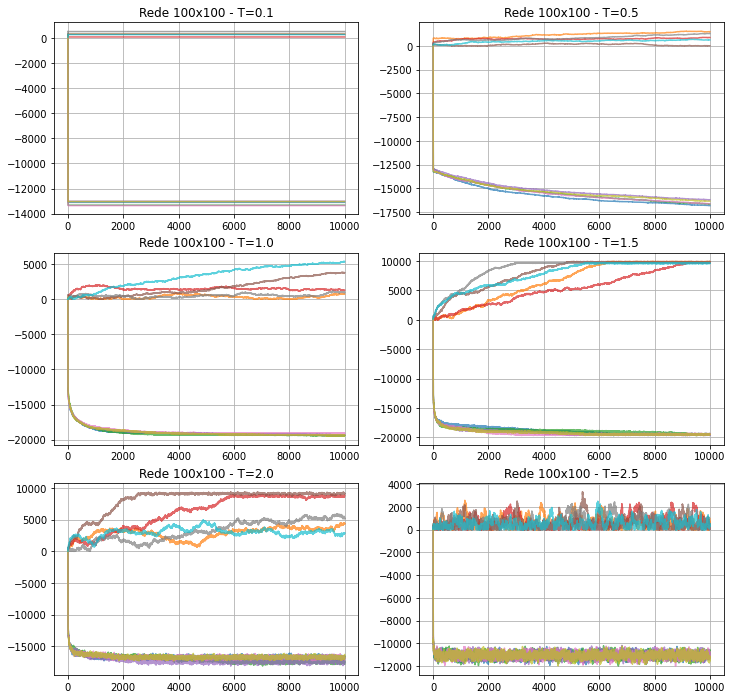

In [23]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
L = 100
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    metropolis_plt(ax, L=100, temp=i, qtd=5, s=None, steps=10000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

Considerando a maior rede requisitada pelo enunciado para simulação, podemos tecer algumas outras conclusões. É interessante notar que o módulo da energia fica muito maior, o que é esperado. Além disso, demora-se muito mais para estabilizar a magnetização, por vezes até mais que 4000 passos. Para a energia, por outro lado, bastam cerca de 2000 passos. Por fim, é importante ressaltar que, em todas as redes, quanto maior a temperatura, mais difícil (ou mais demorado) é de se estabiliazr em um valor, por vezes "estabilizando" em torno de um intervalo ou então não se estabiliza em uma quantidade de passos tolerável, como é o caso de temperaturas muito altas. De forma bizarra, como alertado pelo enunciado, as temperaturas baixas apresentam retas horizontais tanto para magnetização quanto para energia.

### Rede Inicial na Mesma Direção

Vamos agora observar o comportamento quando a rede está inicialmente com todos os spins apontando em uma mesma direção. 

#### 32x32  (todos $+1$)

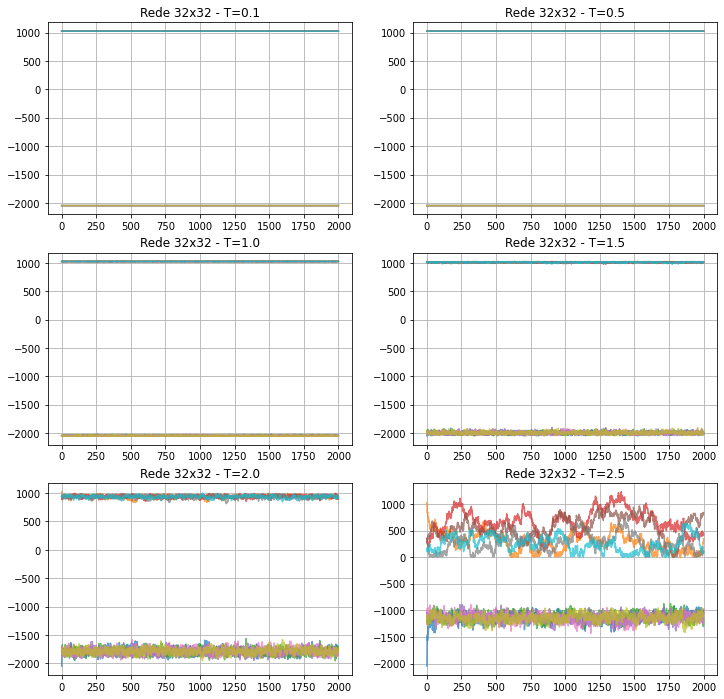

In [11]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    L = 32
    s_up = np.array([1 for i in range(L**2)], dtype=np.float64)        
    metropolis_plt(ax, L=L, temp=i, qtd=5, s=s_up, steps=2000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

É interessante notar que, ate a temperatura de 2.0, as curvas ficam praticamente constantes numa reta horizontal. Além disso, o valor de energia e de magnetização nessas situações é o valor de estabilização que vimos na rede partindo de uma configuração aleatória.

Com o aumento da temperatura, tal como nas situações anteriores, a partir de 2.5, a magnetização para de tender a estabilizar num único patamar. Enquanto isso, a energia oscila em torno de um intervalo próximo do 1000, tal como ocorreu na situação geral.

#### 32x32 (todos $-1$)

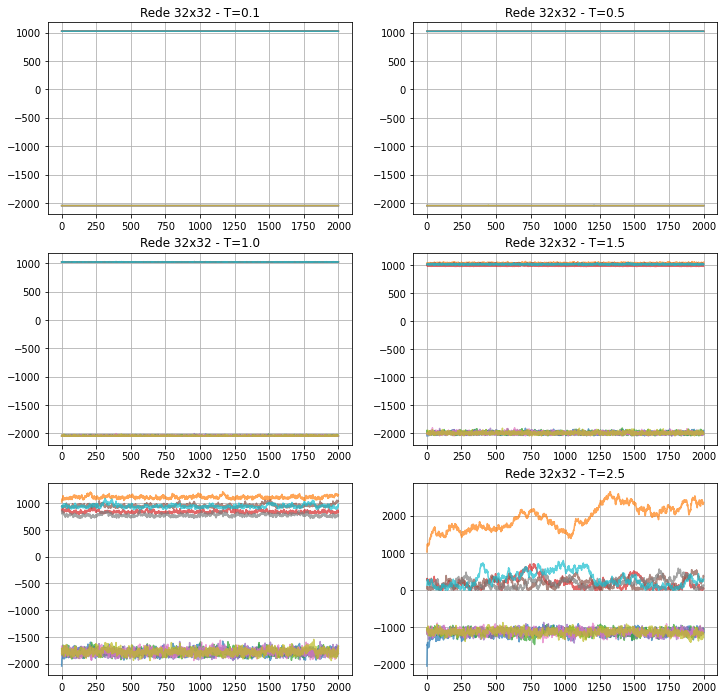

In [12]:
fig, axs = plt.subplots(3, 2,figsize=(12,12))
i = 0
for ax in axs.reshape(-1):
    if (i == 0): i = 0.1
    L = 32
    s_up = np.array([-1 for i in range(L**2)], dtype=np.float64)        
    metropolis_plt(ax, L=L, temp=i, qtd=5, s=s_up, steps=2000)
    if (i == 0.1): i = 0.5
    else: i += 0.5

As conclusões são exatamentes as mesmas da situação anterior com os spins todos em $+1$. Isso evidencia mais uma vez que essas duas configurações são análogas, apenas sinal contrário, visto que seu comportamento e resultados são parecidos senão idênticos. 

### Tempo de Termalização

Apenas para sumarizar os dados numa tabela, vamos compilar o que discutimos nas seções anteriores no que tange à quantidade de passos necessários para que o sistema se estabilize.

| Rede    | Passos (approx.) |
|---------|------------------|
| 24x24   | 300              |
| 32x32   | 750              |
| 64x64   | 1500             |
| 100x100 | 4000             |

Redes inicialmente com todos spins na mesma direção acabam por demorar poucos passos para estabilizar, como vimos, então nem convém colocá-los na tabela.

## OFF

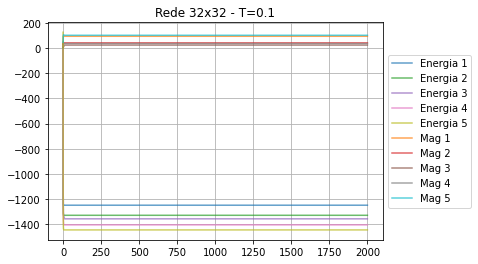

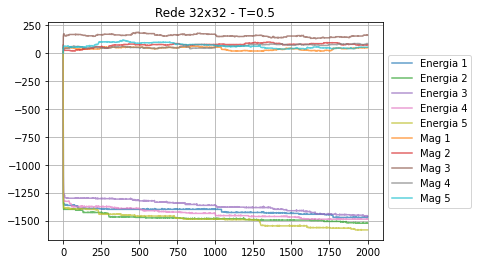

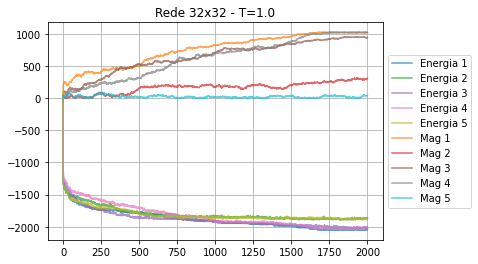

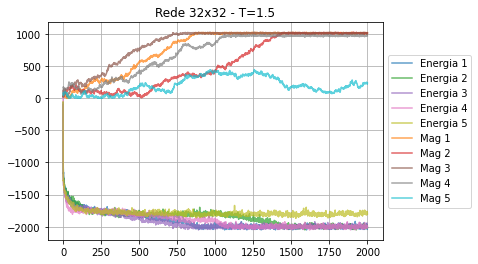

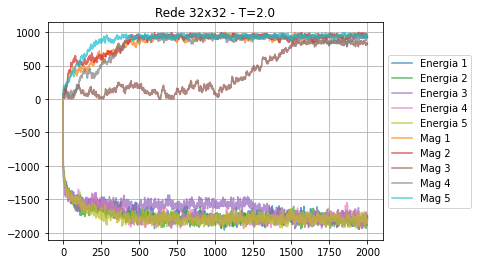

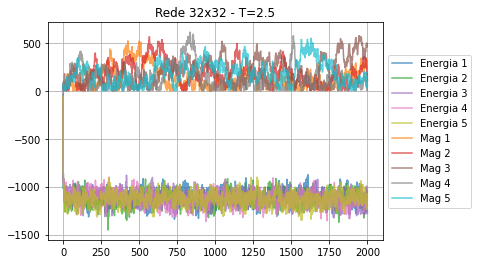

In [141]:
for i in np.arange(0,3,0.5):
    if (i == 0): i = 0.1
    metropolis_plt(32, i, 5)

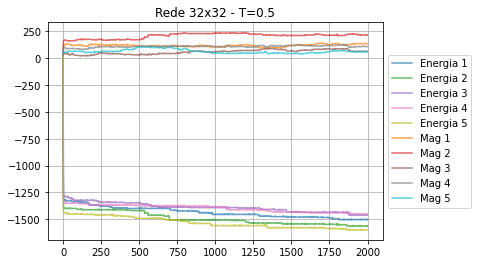

In [135]:
metropolis_plt(32, 0.5, 5)

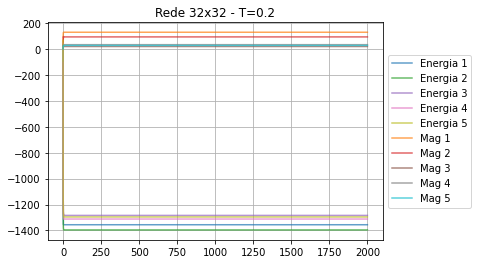

In [136]:
metropolis_plt(32, 0.2, 5)

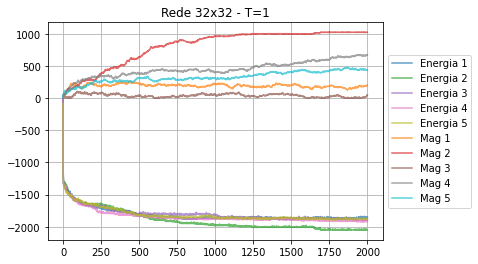

In [137]:
metropolis_plt(32, 1, 5)

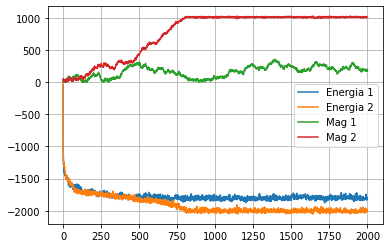

In [74]:
e1, m1 = metropolis(32, 1.5)
e2, m2 = metropolis(32, 1.5)
plt.plot(e1,label="Energia 1")
plt.plot(e2,label="Energia 2")
plt.plot(m1,label="Mag 1")
plt.plot(m2,label="Mag 2")
plt.legend()
plt.grid()
plt.show()

# OFF

In [63]:
@jit(nopython=True)
def mean(vect):
    return np.sum(vect)/len(vect)

In [62]:
@jit(nopython=True)
def metropolis_stable(L, temp, s=None, steps=2000):
    """
    Simula uma rede NxN usando o algoritmo de Metropolis, à temperatura 'temp' (não é o beta)
    Pode receber o estado inicial 's'. Se não fornecido, é escolhido um estado aleatório inicial.
    Retorna dois arrays: energia e magnetização ao longo dos passos do algoritmo
    Por default, são 2000 passos, mas pode ser fornecido outro valor
    """
    # Criação da rede e seus parâmetros
    N = L**2
    beta = 1/temp
    if s is None: s = random_energy_state(N)
    viz = neighbours(N, L)
    ener = energy_ising(s, viz)
    mag = np.abs(np.sum(s))
    
    # Loop principal
    Es, mags = [], []
    Es.append(ener)
    mags.append(mag)
    for i in range(steps):
        ener, mag, s = mcstep(beta, s, viz, ener, mag)
        Es.append(ener)
        mags.append(np.abs(mag))
        if (i % 500 == 0):
            res = stable(Es)
            print(res)
            print(stable(mags))
    return Es, mags

In [64]:
@jit(nopython=True)
def stable(vect, N=3, interval=50, tolerance=1.0):
    """
    Verifica se uma sequência de números estabilizou em torno de uma média.
    O algoritmo avalia médias de segmentos dessa sequência e verifica se as N
    últimas médias são iguais
    """
    if (len(vect) < interval):
        # Vetor menor que intervalo
        interval = int(len(vect)/N)
    
    for i in range(N):
        if (i == 0):
            med0 = np.mean(np.array(vect[-1*interval:]))
            med1 = np.mean(np.array(vect[-2*interval:-interval]))
        else:
            med0 = np.mean(np.array(vect[-(i+1)*interval:-i*interval]))
            med1 = np.mean(np.array(vect[-(i+2)*interval:-(i+1)*interval]))
        if (np.abs(med0 - med1) > tolerance):
            return False
    return True

In [71]:
stable([6,6,6,6,6,6,6,7,6,6,6,6,6,6,6,6,6,6,6,6,])

True

In [11]:
L = 32
N = L**2
temp = 1.5
beta = 1/temp

s = random_energy_state(N)
viz = neighbours(N, L)
ener = energy_ising(s, viz)
mag = np.sum(s)

In [15]:
MAX_STEPS = 100000
Es, mags = [], []

Es.append(ener)
mags.append(mag)

for i in range(MAX_STEPS):
    ener, mag, s = mcstep(beta, s, viz, ener, mag)
    Es.append(ener)
    mags.append(mag)

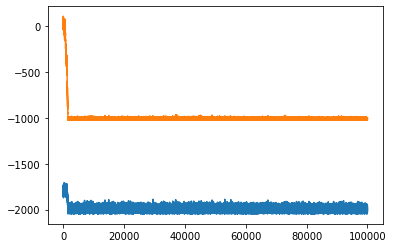

In [16]:
plt.plot(Es)
plt.plot(mags)